In [80]:
%matplotlib inline
import wikiquote
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.corpus import stopwords
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

# Thinkful Data Science: Unsupervised Learning Capstone 

### Corey Coole

### August 18, 2019

#### - Objective: 
    
        Pick a set of texts, process the texts and apply a series of unsupervised clustering methods to group the 
        texts. 
        Now analyze which clustering method groups the texts most consistely with respect to the person of 
        interest. 
        Apply supervised and unsupervised permutations of feature selection and generation to build a model 
        that will classify the texts by person of interest. 
        Lastly, evaluate this model against a holdout group of 25%, analyze the consistency of its prediction and 
        explain any notable divergencies.  

#### - Data Source: Wikiquote.org
#### - Pull 700 quotes from 10 wikiquote archives (70 per).
#### - Persons of interest: 
               
               Plato, Socrates, Sigmund Frued, Friedrich Nietzsche, René Descartes, Immanuel Kant,
               David Hume, Bertrand Russell, John Locke, Noam Chomsky

        

# Text Processing 

- Create a data frame containing cleaned texts from each person of interest. 

In [81]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()

def get_quotes(author): # a function to grab and clean quotes from wikiquote webarchive
    quotes = wikiquote.quotes(author, max_quotes=70)

    sent_list_clean = []

    # Iterate through sentence list, removing punctuation, numeric values
    for quote in quotes:
        quote = re.sub("[^a-zA-Z]", ' ', quote) #remove numeric and punctuation
                                                #replace with blank
        sent_list_clean.append(quote)

    # Create list to hold lemmatized sentences
    lemma_sents = []

    # Tokenize, get lemmas, and rejoin back to sentence level doc
    for sent in sent_list_clean:
        words = word_tokenize(sent)                                 
        word_lemma = [lemmatizer.lemmatize(word) for word in words] 
        sent_lemma = ' '.join(word_lemma)                           
        lemma_sents.append(sent_lemma)

    res = pd.DataFrame(lemma_sents,columns = ['Quote'])
    res = res.assign(Author=author)
    return res

In [82]:
df_plato = get_quotes('Plato') # process quotes from 10 individuals 
df_freud = get_quotes('Sigmund Freud')
df_socrates = get_quotes('Socrates')
df_nietzsche = get_quotes('Friedrich Nietzsche')
df_descartes = get_quotes('René Descartes')
df_kant = get_quotes('Immanuel Kant')
df_hume = get_quotes('David Hume')
df_russell = get_quotes('Bertrand Russell')
df_locke = get_quotes('John Locke')
df_chomsky = get_quotes('Noam Chomsky')

In [4]:
df_plato.head()

,Quote,Author
0,Let every man remind their descendant that the...,Plato
1,Rhetoric it seems is a producer of persuasion ...,Plato
2,Then the case is the same in all the other art...,Plato
3,The orator and the despot have the least power...,Plato
4,It would be better for me that multitude of me...,Plato


In [5]:
df_authors = pd.DataFrame() # combine all persons of interest into one accessible dataframe

df_authors = df_authors.append([df_plato, df_freud, df_socrates, df_nietzsche, df_descartes,
                               df_kant, df_hume, df_russell, df_locke, df_chomsky], ignore_index = True)
df_authors.head()

,Quote,Author
0,Let every man remind their descendant that the...,Plato
1,Rhetoric it seems is a producer of persuasion ...,Plato
2,Then the case is the same in all the other art...,Plato
3,The orator and the despot have the least power...,Plato
4,It would be better for me that multitude of me...,Plato


In [6]:
# Defining X and Y variables
X = df_authors.Quote
Y = df_authors.Author

# Feature Generation: Tf-idf Vectorization

- Term frequency-inverse document frequency (TF-IDF): 
    
    A numerical statistic that is intended to reflect how important a word is to a document in a collection or 
    corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user 
    modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is 
    offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that 
    some words appear more frequently in general. 

In [119]:
#Calculate our TF-IDF vector matrix using TfidfVectorizer. 
#This allows us to clean up more our sentences removing stop words and applying lowercase to all text.

vectorizer = TfidfVectorizer(stop_words='english', # Remove stop words
                             lowercase=True,       # Convert all to lowercase
                             min_df=2,             # Use words that appear at least twice per sentence
                             max_df=0.5,           # Drop words that occur in more than half of the sentences
                             use_idf=True,
                             smooth_idf=True,
                             norm='l2'
                             )
#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets. Reserving 25% of my corpus as a test set.
X_train_tfidf, X_test_tfidf, Y_train_tfidf, Y_test_tfidf = train_test_split(X_tfidf, 
                                                                Y,
                                                                test_size=0.25,
                                                                random_state=0)

Number of features: 2689


In [129]:
Y_test_tfidf.head()

306      René Descartes
604          John Locke
40                Plato
493    Bertrand Russell
14                Plato
Name: Author, dtype: object

## Dimensionality Reduction

-  Singular Value Decomposition:
    
    A matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent 
    matrix calculations simpler.
    This transformer performs linear dimensionality reduction by means of truncated singular value decomposition 
    (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value 
    decomposition. This means it can work with scipy.sparse matrices efficiently.
    

In [8]:
from sklearn.decomposition import TruncatedSVD

for i in range(200, 1100, 100):
    svd= TruncatedSVD(i)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD on the training data, then project the training data.
    X_train_lsa = lsa.fit_transform(X_train_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print(i)
    print("Percent variance captured by all components:",total_variance*100)

200
Percent variance captured by all components: 63.27091764592097
300
Percent variance captured by all components: 79.90167797218629
400
Percent variance captured by all components: 91.65215892049801
500
Percent variance captured by all components: 99.15826649787394
600
Percent variance captured by all components: 99.99999999999997
700
Percent variance captured by all components: 100.00000000000004
800
Percent variance captured by all components: 100.0
900
Percent variance captured by all components: 100.00000000000004
1000
Percent variance captured by all components: 100.0


In [122]:
# From the code above, I'm going to reduce the feature space from 2689 to 700. 

svd= TruncatedSVD(700)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 100.00000000000004


In [125]:
X_test_lsa.shape

(175, 525)

# Tf-idf Cluster Analysis

- Investigating K-means, Mean Shift, Spectral Clustering, Afinity Propogation unsupervised clustering methods on the Tf-idf vectorization.

## K-Means
-  K-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

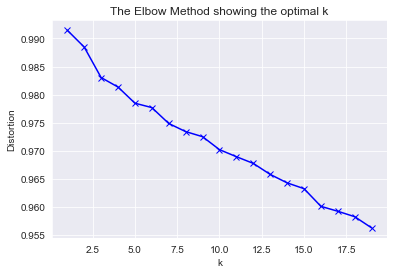

In [14]:
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_train_lsa)
    kmeanModel.fit(X_train_lsa)
    distortions.append(sum(np.min(cdist(X_train_lsa, kmeanModel.cluster_centers_, 'euclidean'), 
                                  axis=1)) / X_train_lsa.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [12]:
# Normalize the data.
X_norm = normalize(X_train_lsa)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

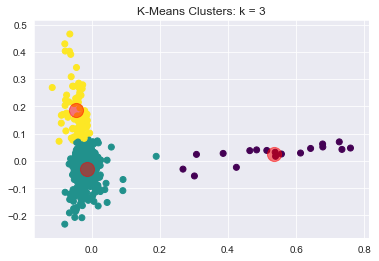

Comparing K-Means Clusters Against the Data:
col_0                 0   1   2
Author                         
Bertrand Russell      0  46   3
David Hume            0  51   0
Friedrich Nietzsche  13  31   3
Immanuel Kant         2  44   5
John Locke            0  56   0
Noam Chomsky          0  48   6
Plato                 0  39  10
René Descartes        0  15  38
Sigmund Freud         3  53   3
Socrates              0  54   2


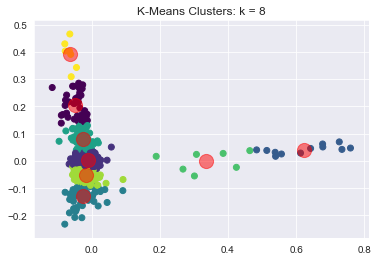

Comparing K-Means Clusters Against the Data:
col_0                 0   1  2   3   4  5   6  7
Author                                          
Bertrand Russell      0  19  0   7   5  0  18  0
David Hume            0  29  0   1   1  0  20  0
Friedrich Nietzsche   3   8  9   3   5  4  15  0
Immanuel Kant         0  20  1   4  12  1  13  0
John Locke            0  23  0   8   0  0  25  0
Noam Chomsky          5  32  0   0   6  0  11  0
Plato                 7  18  0   6   7  0  11  0
René Descartes       19   5  0   0  18  0   4  7
Sigmund Freud         1  30  2   2   4  2  18  0
Socrates              1   4  0  32   1  0  18  0


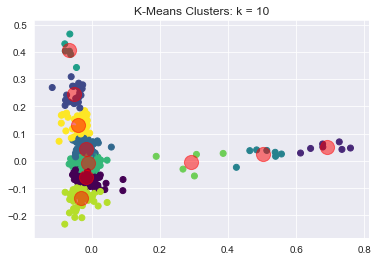

Comparing K-Means Clusters Against the Data:
col_0                 0  1   2   3  4  5   6  7   8   9
Author                                                 
Bertrand Russell     15  0   0   5  0  0  21  0   6   2
David Hume           13  0   0   8  0  0  29  0   1   0
Friedrich Nietzsche  11  7   1   6  3  0  12  3   2   2
Immanuel Kant         9  0   0  13  1  0  20  1   3   4
John Locke           18  0   0   3  0  0  27  0   8   0
Noam Chomsky          7  0   3  13  0  0  28  0   0   3
Plato                11  0   4   8  0  0  18  0   4   4
René Descartes        2  0  12   7  0  6   7  0   0  19
Sigmund Freud        14  0   0   6  3  0  31  1   1   3
Socrates             21  0   1   1  0  0   3  0  29   1


In [13]:
K_values = [3,8,10]
for i in K_values: 
    y_pred = KMeans(n_clusters=i, random_state=42).fit_predict(X_pca)
    estimator = KMeans(n_clusters=i, random_state=42).fit(X_pca)
    centers = estimator.cluster_centers_
    
    # Plot the solution.
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y_pred, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1], c='r', s=200, alpha=0.5);
    plt.title('K-Means Clusters: k = {}'.format(i))
    plt.show()

    # Check the solution against the data.
    print('Comparing K-Means Clusters Against the Data:')
    print(pd.crosstab(Y_train, y_pred))

- From each cluster iteration's crosstable there seems to be no definitive textual partitioning amongst the persons of interest.

# Cluster Evaluation Metrics

## Adjusted Rand Index: 
    
    Rand index adjusted for chance.
    The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and 
    counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
    The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the 
    number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).


## Silhuoette Score: 
    
    Calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. 
    The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample 
    and the nearest cluster that the sample is not a part of. The best value is 1 and the worst value is -1. Values 
    near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the 
    wrong cluster, as a different cluster is more similar.

In [15]:
# Evaluate the performance of the clusters with the Adjusted Rand Index and Sillouette values.
K_values = [3,8,10]

for i in K_values: 
    y_pred = KMeans(n_clusters=i, random_state=42).fit_predict(X_train_lsa)

    print('{} Clusters:'.format(i))
    print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(Y_train, y_pred)))
    print('Silhouette Score: {:0.7}'.format(silhouette_score(X_train_lsa, y_pred, metric='euclidean')))
    print('\n')

3 Clusters:
Adjusted Rand Score: 0.02685461
Silhouette Score: 0.00762575


8 Clusters:
Adjusted Rand Score: 0.05312629
Silhouette Score: 0.007720029


10 Clusters:
Adjusted Rand Score: 0.06448301
Silhouette Score: 0.008096992




- The K-means algorithm does not seem to return a meaningful partioning of the text data in any iteration of k-value.

In [16]:
km = KMeans(n_clusters=10, random_state=42).fit(X_train_lsa)
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 abandon
 abstract
 abstracted
 abstruse
 accomplish
 acceptable
 absolutely
 absurdity
 accident
 administration
Cluster 1:
 abandon
 abuse
 abstraction
 achievement
 accident
 acting
 affection
 administration
 actually
 abstain
Cluster 2:
 abandon
 ability
 accept
 absolutely
 addressed
 accord
 air
 adventurer
 added
 advanced
Cluster 3:
 abandon
 accepts
 ability
 achievement
 able
 account
 absurdity
 activity
 abuse
 accept
Cluster 4:
 abandon
 achieve
 abstracted
 accident
 achieving
 activity
 acceptance
 accepting
 achieved
 amazing
Cluster 5:
 aber
 abandon
 able
 abstract
 absolute
 account
 acting
 acceptance
 anti
 adjust
Cluster 6:
 abandon
 aber
 abstain
 absurd
 accepts
 acquiring
 accuser
 aid
 acquainted
 advance
Cluster 7:
 abandon
 absolute
 accidental
 according
 able
 added
 acceptance
 actual
 accepts
 admit
Cluster 8:
 abandoned
 abandon
 aber
 al
 alcibiades
 ago
 advantage
 afford
 agree
 assumed
Cluster 9:
 abandon
 accustomed
 achievement
 accide

- We see at a cluster number of 10 there are numerous instances of the same word occuring in seperate clusters. 

In [ ]:
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_train_lsa)

bow_cluster3_df = poems_df.copy()
bow_cluster3_df['cluster'] = y_pred

g = sns.factorplot("authors", col="cluster", col_wrap=3,data=bow_cluster3_df,kind="count", aspect=1.5)
g.set_xticklabels(rotation=30)
plt.subplots_adjust(top=0.8)
plt.suptitle('Authors by Cluster', fontsize=26)
plt.show()

## Mean Shift
- Mean shift clustering aims to discover “blobs” in a smooth density of samples. It is a centroid-based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

In [18]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

y_pred_mean = ms.fit_predict(X_train_lsa)

# Coordinates of the cluster centers.
#cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}\n".format(n_clusters_))

print('Adjusted Rand Score: {:0.7}\n'.format(adjusted_rand_score(Y_train, y_pred_mean)))

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train,labels))

Number of estimated clusters: 1

Adjusted Rand Score: 0.0

Comparing the assigned categories to the ones in the data:
col_0                 0
Author                 
Bertrand Russell     49
David Hume           51
Friedrich Nietzsche  47
Immanuel Kant        51
John Locke           56
Noam Chomsky         54
Plato                49
René Descartes       53
Sigmund Freud        59
Socrates             56


- The Mean Shift algorithm did not score highly and assumed only one cluster for all textual data.

## Spectral Clustering
- A technique with roots in graph theory, where the approach is used to identify communities of nodes in a graph based on the edges connecting them. Spectral clustering uses information from the eigenvalues (spectrum) of special matrices built from the data set.

In [21]:
# Pick the number of clusters.
n_clusters= 10

# Initialize the model.
sc = SpectralClustering(n_clusters=n_clusters)

# Fit and predict the model.
y_pred_spectral = sc.fit_predict(X_train_lsa)

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(Y_train, y_pred_spectral)))
print('Silhouette Score: {:0.7}\n'.format(silhouette_score(X_train_lsa, y_pred_spectral, metric='euclidean')))

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train,y_pred_spectral))

Adjusted Rand Score: 0.04836032
Silhouette Score: 0.01622993

Comparing the assigned categories to the ones in the data:
col_0                 0  1   2   3  4  5  6   7   8   9
Author                                                 
Bertrand Russell      7  0   0   1  0  0  0  27  14   0
David Hume            1  0   0   0  0  0  0  38  12   0
Friedrich Nietzsche   2  3  10   3  0  0  0  20   9   0
Immanuel Kant         6  0   2   1  0  0  0  35   7   0
John Locke           17  0   0   0  0  0  0  20  16   3
Noam Chomsky         14  1   0   6  0  0  0  24   9   0
Plato                 6  0   0  10  1  1  1  15  11   4
René Descartes        0  0   0  25  0  0  0  22   6   0
Sigmund Freud         0  0   3   3  0  0  0  42  10   1
Socrates              0  0   0   1  1  1  1   7  31  14


- Although better than the Mean Shift method, the Spectral Clustering algorithm did not achieve an improvement to overall clustering consistency.

## Afinity Propogation
- In Affinity Propagation the data points can be seen as a network where all the data points send messages to all other points. The subject of these messages are the willingness of the points being exemplars. Exemplars are points that explain the other data points ‘best’ and are the most significant of their cluster. A cluster only has one exemplar. All the data points want to collectively determine which data points are an exemplar for them.

In [22]:
af = AffinityPropagation().fit(X_train_lsa)

y_pred_affinity = af.fit_predict(X_train_lsa)

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(Y_train, y_pred_affinity)))
print('Silhouette Score: {:0.7}\n'.format(silhouette_score(X_train_lsa, y_pred_affinity, metric='euclidean')))

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train,y_pred_affinity))

Adjusted Rand Score: 0.04632585
Silhouette Score: 0.03125006

Comparing the assigned categories to the ones in the data:
col_0                0   1   2   3   4   5   6   7   8   9  ...  78  79  80  \
Author                                                      ...               
Bertrand Russell      0   0   0   0   0   0   0   0   1   0 ...   0   0   0   
David Hume            5   0   0   0   0   0   0   0   2   0 ...   0   0   0   
Friedrich Nietzsche   0   0   0   1   0   0   0   0   3   0 ...   0   0   0   
Immanuel Kant         1   0   0   1   3   0   0   0   0   3 ...   0   0   1   
John Locke            0   1   0   1   1   1   0   0   0   0 ...   0   0   0   
Noam Chomsky          0   0   4   0   0   0   0   1   2   0 ...   0   1   0   
Plato                 0   0   1   0   0   3   0   0   0   0 ...   0   0   0   
René Descartes        0   0   0   0   1   1   0   0   1   2 ...   3   0   3   
Sigmund Freud         0   0   0   3   0   1   3   3   2   0 ...   0   2   0   
Socrates  

- The Affinity Propogation method has returned the highest ARS and Silluoette values, however we see from the crosstable analysis that there are still instances of persons of interest sharing multiple clusters.

In [23]:
order_centroids = af.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 admittedly
 aside
 assistance
 age
 anytus
 abandon
 acquiring
 adventurer
 admitting
 cognitive
Cluster 1:
 according
 admit
 abandon
 accidental
 added
 actual
 able
 accident
 appears
 apprehend
Cluster 2:
 activity
 achieving
 aber
 abandon
 assent
 accepts
 abstract
 calling
 children
 bacon
Cluster 3:
 afford
 advancement
 aim
 algebra
 action
 adjust
 assume
 admirable
 carry
 allows
Cluster 4:
 analogous
 ambition
 ages
 abstain
 allows
 angle
 assistance
 arithmetic
 analytic
 century
Cluster 5:
 ascribe
 acting
 addition
 altogether
 antagonism
 acquiring
 attempted
 abandon
 affair
 begin
Cluster 6:
 brings
 absolute
 breath
 authority
 abandon
 attribute
 attended
 actuality
 activity
 adequately
Cluster 7:
 achieving
 admitting
 adequately
 adequate
 addition
 aid
 accustomed
 animal
 aggression
 aimless
Cluster 8:
 abstruse
 abandon
 ability
 counterpart
 acquainted
 acceptable
 abstraction
 corrupt
 according
 accepts
Cluster 9:
 act
 accident
 acquaintance
 

- Similar to the K-means method, instances of specific words are found to be grouped in multiple clusters. 

- Overall, Tf-idf did not return consistent results, a possible explanation may be that there may not of been enough words in the matrix that carried individual weights or there were too many words that didn't have much value in the matrix.

# Feature Generation: Bags of Words
- A simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

In [24]:
plato = wikiquote.quotes('Plato', max_quotes=50)
freud = wikiquote.quotes('Sigmund Freud', max_quotes=50)
socrates = wikiquote.quotes('Socrates', max_quotes=50)
nietzsche = wikiquote.quotes('Friedrich Nietzsche', max_quotes=50)
descartes = wikiquote.quotes('René Descartes', max_quotes=50)
kant = wikiquote.quotes('Immanuel Kant', max_quotes=50)
hume = wikiquote.quotes('David Hume', max_quotes=50)
russell = wikiquote.quotes('Bertrand Russell', max_quotes=50)
locke = wikiquote.quotes('John Locke', max_quotes=50)
chomsky = wikiquote.quotes('Noam Chomsky', max_quotes=50)

In [25]:
stopwords_eng = set(stopwords.words("english"))

def clean_quote(raw_quote): # create a function to return cleaned text
    """
    Function to clean quote text to keep only letters and remove stopwords
    Returns a string of the cleaned quote text
    """
    raw_quote = str(raw_quote).strip('[]')
    letters_only = re.sub('[^a-zA-Z]', ' ', raw_quote)
    words = letters_only.lower().split()
    useful_words = [x for x in words if not x in stopwords_eng]
    
    # Combine words into a paragraph again
    useful_words_string = ' '.join(useful_words)
    return(useful_words_string)

In [26]:
plato = clean_quote(plato)
freud = clean_quote(freud)
socrates = clean_quote(socrates)
nietzsche = clean_quote(nietzsche)
descartes = clean_quote(descartes)
kant = clean_quote(kant)
hume = clean_quote(hume)
russell = clean_quote(russell)
locke = clean_quote(locke)
chomsky = clean_quote(chomsky)

In [27]:
# run spaCy and analyze the documents
nlp = spacy.load('en')

plato_doc = nlp(plato)
freud_doc = nlp(freud)
socrates_doc = nlp(socrates)
nietzsche_doc = nlp(nietzsche)
descartes_doc = nlp(descartes)
russell_doc = nlp(russell)
kant_doc = nlp(kant)
hume_doc = nlp(hume)
locke_doc = nlp(locke)
chomsky_doc = nlp(chomsky)

In [28]:
plato_doc

let every man remind descendants also soldiers must desert ranks ancestors cowardice fall behind even exhort day future time whenever meet shall continue remind exhort ye sons heroes strive bravest men think ought repeat fathers desired said survivors went battle case anything happened tell heard say speech would fain saying judging said must imagine hear saying repeat sons event proves fathers brave men might lived dishonourably preferred die honourably rather bring children disgrace rather dishonour fathers forefathers considering life life one dishonour race one neither men gods friendly either earth death world remember words whatever aim let virtue condition attainment aim know without possessions pursuits dishonourable evil neither wealth bring honour owner coward one wealth belongs another beauty strength body dwelling base cowardly man appear comely reverse comely making possessor conspicuous manifesting forth cowardice knowledge separated justice virtue seen cunning wisdom whe

In [31]:
# Utility function to create a list of the 1500 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1500)]

In [32]:
# Set up the bags.
plato_words = bag_of_words(plato_doc)
freud_words = bag_of_words(freud_doc)
socrates_words = bag_of_words(socrates_doc)
nietzsche_words = bag_of_words(nietzsche_doc)
descartes_words = bag_of_words(descartes_doc)
russell_words = bag_of_words(russell_doc)
kant_words = bag_of_words(kant_doc)
hume_words = bag_of_words(hume_doc)
locke_words = bag_of_words(locke_doc)
chomsky_words = bag_of_words(chomsky_doc)

In [33]:
# Group into sentences
plato_sents = [[sent, 'Plato'] for sent in plato_doc.sents]
freud_sents = [[sent, 'Freud'] for sent in freud_doc.sents]
socrates_sents = [[sent, 'Socrates'] for sent in socrates_doc.sents]
nietzsche_sents = [[sent, 'Nietzsche'] for sent in nietzsche_doc.sents]
descartes_sents = [[sent, 'Descartes'] for sent in descartes_doc.sents]
russell_sents = [[sent, 'Russell'] for sent in russell_doc.sents]
kant_sents = [[sent, 'Kant'] for sent in kant_doc.sents]
hume_sents = [[sent, 'Hume'] for sent in hume_doc.sents]
locke_sents = [[sent, 'Locke'] for sent in locke_doc.sents]
chomsky_sents = [[sent, 'Chomsky'] for sent in chomsky_doc.sents]

In [35]:
plato_sents

[[let every man remind descendants also soldiers must desert ranks ancestors cowardice fall behind even exhort day future time whenever meet shall continue remind exhort ye sons heroes strive bravest men think ought repeat fathers desired said survivors went battle case anything happened tell heard say speech would fain saying judging said must imagine hear saying repeat sons event proves fathers brave men might lived dishonourably preferred die honourably rather bring children disgrace rather dishonour fathers forefathers considering life life one dishonour race,
  'Plato'],
 [one neither men gods friendly either earth death world remember words whatever aim let virtue condition attainment aim know without possessions pursuits dishonourable evil neither wealth bring honour owner coward one wealth belongs another beauty strength body dwelling base cowardly man appear comely reverse comely making possessor conspicuous manifesting forth cowardice knowledge separated justice virtue seen c

In [36]:
# Combine the sentences from the 10 novels into one data frame.
sentences = pd.DataFrame(plato_sents + freud_sents + socrates_sents + nietzsche_sents + descartes_sents + kant_sents + 
                 hume_sents + russell_sents + locke_sents + chomsky_sents)

In [37]:
sentences.head()

,0,1
0,"(let, every, man, remind, descendants, also, s...",Plato
1,"(one, neither, men, gods, friendly, either, ea...",Plato
2,"(last, constant, absorbing, aim, exceed, possi...",Plato
3,"(excel, virtue, brings, us, shame, excelled, s...",Plato
4,"(nothing, dishonourable, honoured, sake, accou...",Plato


In [38]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [39]:
authors_words = [plato_words, freud_words, socrates_words, nietzsche_words, descartes_words, kant_words, 
                 hume_words, russell_words, locke_words, chomsky_words]

for i in authors_words:
    print(len(i))

652
543
618
1394
1128
901
937
719
671
949


In [40]:
# Combine bags to create a set of unique words.
common_words = set(plato_words + freud_words + socrates_words + nietzsche_words + descartes_words + kant_words + 
                 hume_words + russell_words + locke_words + chomsky_words)

# How many words we got?
len(common_words)

4790

In [37]:
# Create our data frame with features. This can take a while to run.
#word_counts = bow_features(sentences, common_words)
#word_counts.head()

Processing row 0
Processing row 500


,take,restrain,kunst,advancement,cultivation,effectively,dependent,helicopter,phenomenon,fade,...,help,turkey,touch,pound,north,recognize,david,nde,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(let, every, man, remind, descendants, also, s...",Plato
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(one, neither, men, gods, friendly, either, ea...",Plato
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(last, constant, absorbing, aim, exceed, possi...",Plato
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(excel, virtue, brings, us, shame, excelled, s...",Plato
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(nothing, dishonourable, honoured, sake, accou...",Plato


In [144]:
#Download word_counts dataframe and save as csv file

#word_counts.to_csv("bow.csv",index=False)

df_bow = pd.read_csv('bow.csv', sep=',')
#df_bow.head()

In [43]:
X_bow = df_bow.drop(['text_sentence','text_source'],axis=1)
Y_bow = df_bow['text_source']

In [44]:
#splitting into training and test sets. Reserving 25% of my corpus as a test set.
X_train_bow, X_test_bow, Y_train_bow, Y_test_bow = train_test_split(X_bow, 
                                                                Y_bow,
                                                                test_size=0.25,
                                                                random_state=0)

# Bag of Words Cluster Analysis
- Investigating K-means, Mean Shift, Spectral Clustering, Afinity Propogation unsupervised clustering methods on the Bag of Words textual processing.

## Dimensionality Reduction

In [45]:
for i in range(200, 1100, 100):
    svd= TruncatedSVD(i)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD on the training data, then project the training data.
    X_train_bow_lsa = lsa.fit_transform(X_train_bow)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print(i)
    print("Percent variance captured by all components:",total_variance*100)

200
Percent variance captured by all components: 87.98856253774599
300
Percent variance captured by all components: 95.06603486565895
400
Percent variance captured by all components: 98.45850909843944
500
Percent variance captured by all components: 99.86593223553137
600
Percent variance captured by all components: 100.0
700
Percent variance captured by all components: 100.00000000000003
800
Percent variance captured by all components: 100.00000000000003
900
Percent variance captured by all components: 100.00000000000009
1000
Percent variance captured by all components: 100.00000000000007


In [46]:
svd= TruncatedSVD(700)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_bow_lsa = lsa.fit_transform(X_train_bow)
X_test_bow_lsa = lsa.transform(X_test_bow)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 100.00000000000004


# K Means

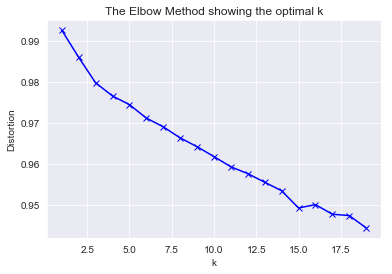

In [50]:
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_train_bow_lsa)
    kmeanModel.fit(X_train_bow_lsa)
    distortions.append(sum(np.min(cdist(X_train_bow_lsa, kmeanModel.cluster_centers_, 'euclidean'), 
                                  axis=1)) / X_train_bow_lsa.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [51]:
# Normalize the data.
X_bow_norm = normalize(X_train_bow_lsa)

# Reduce it to two components.
X_bow_pca = PCA(2).fit_transform(X_bow_norm)

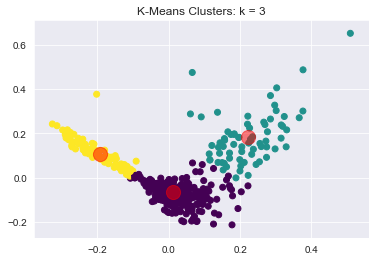

Comparing K-Means Clusters Against the Data:
col_0         0   1   2
text_source            
Chomsky      33   2   0
Descartes    53   0   0
Freud        23   3   4
Hume         44   8   0
Kant         41   4   3
Locke        21  13   0
Nietzsche    56   6  97
Plato        29   6   0
Russell      40   4   0
Socrates     25  25   1


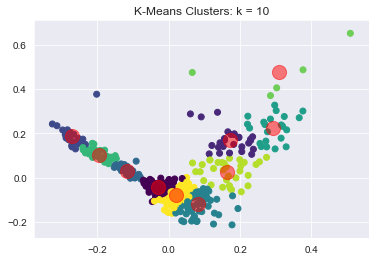

Comparing K-Means Clusters Against the Data:
col_0         0  1   2   3   4   5   6  7  8   9
text_source                                     
Chomsky      13  1   0   0   5   1   0  0  0  15
Descartes    13  0   0   0  22   0   0  0  0  18
Freud        13  2   0   1   1   0   3  1  0   9
Hume         21  5   0   0   6   0   0  1  6  13
Kant         15  1   0   2   7   1   1  0  3  18
Locke        13  3   0   0   3   5   0  0  5   5
Nietzsche    38  4  28  37   2   0  40  1  3   6
Plato        10  3   0   0   7   2   0  0  4   9
Russell      11  2   0   0  11   1   0  0  2  17
Socrates      8  6   0   0   4  12   1  2  9   9


In [52]:
K_values = [3,10]
for i in K_values: 
    y_pred = KMeans(n_clusters=i, random_state=42).fit_predict(X_bow_pca)
    estimator = KMeans(n_clusters=i, random_state=42).fit(X_bow_pca)
    centers = estimator.cluster_centers_
    
    # Plot the solution.
    plt.scatter(X_bow_pca[:, 0], X_bow_pca[:, 1], c = y_pred, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1], c='r', s=200, alpha=0.5);
    plt.title('K-Means Clusters: k = {}'.format(i))
    plt.show()

    # Check the solution against the data.
    print('Comparing K-Means Clusters Against the Data:')
    print(pd.crosstab(Y_train_bow, y_pred))

In [53]:
# Evaluate the performance of the clusters
K_values = [3,10]

for i in K_values: 
    
    km = KMeans(n_clusters=i, random_state=42).fit(X_train_bow_lsa).fit(X_train_bow_lsa)
    
    y_pred_kmeans = km.predict(X_train_bow_lsa)
    
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    
    print('{} Clusters:'.format(i))
    print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(Y_train_bow, y_pred_kmeans)))
    print('Silhouette Score: {:0.7}'.format(silhouette_score(X_train_bow_lsa, y_pred_kmeans, metric='euclidean')))
    print('\n')

3 Clusters:
Adjusted Rand Score: 0.04481989
Silhouette Score: 0.0106454


10 Clusters:
Adjusted Rand Score: 0.0261531
Silhouette Score: 0.009398335




- Similar to the Tf-idf, K-means clustering applied to the BoW data did not return consistent clustering.

In [89]:
km = KMeans(n_clusters=10, random_state=42).fit(X_train_bow_lsa)
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 abandon
 background
 achieving
 afraid
 amusement
 aggression
 actuality
 appeared
 affect
 convention
Cluster 1:
 abandon
 absurd
 aber
 able
 accidental
 accord
 abandoned
 abstract
 administration
 achieving
Cluster 2:
 accomplish
 anti
 alive
 aspect
 assurance
 asked
 appeared
 applies
 ancestor
 based
Cluster 3:
 abandon
 abuse
 acquired
 appreciation
 affair
 acting
 affection
 arrived
 abstracted
 advance
Cluster 4:
 abandon
 achieve
 accept
 accepts
 accordance
 accordingly
 acceptance
 affirm
 agent
 adequate
Cluster 5:
 abandon
 acquiring
 actual
 addition
 angle
 accord
 accepting
 acquainted
 angry
 antagonist
Cluster 6:
 accomplish
 accomplished
 according
 account
 adequate
 afraid
 accordance
 administration
 addition
 angry
Cluster 7:
 accomplish
 adjust
 adequately
 accomplished
 actuality
 affirm
 added
 abuse
 acceptance
 according
Cluster 8:
 abandon
 accomplished
 abuse
 acceptable
 ability
 admonished
 absolute
 actual
 aggressiveness
 aim
Cluster 9:


- We seem multiple instances from the K-means method where specific words were grouped in multiple clusters.

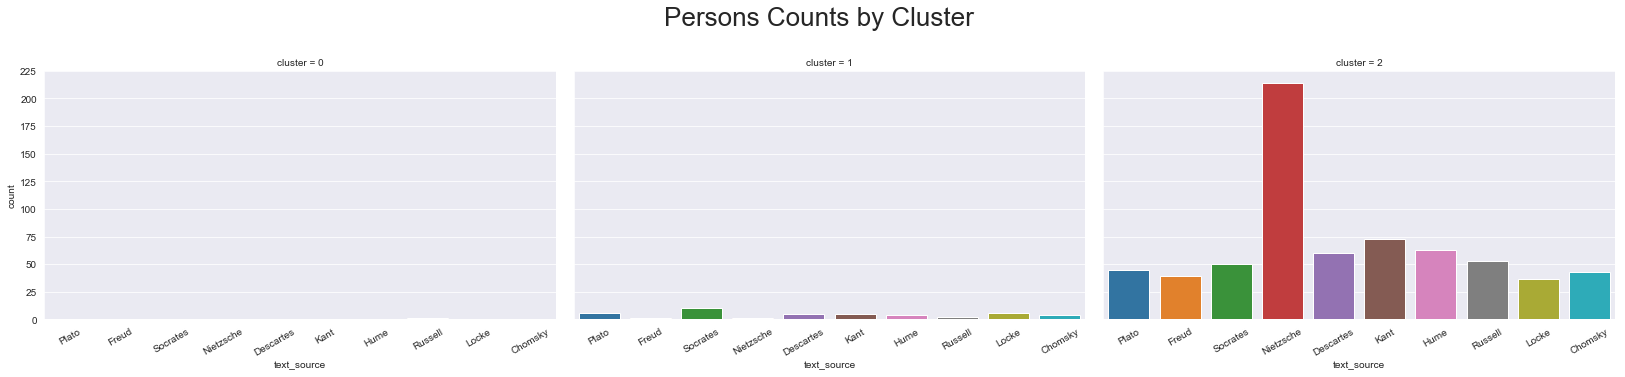

In [100]:
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_bow)

df_bow2 = df_bow.copy()
df_bow2['cluster'] = y_pred

g = sns.factorplot("text_source", col="cluster", col_wrap=3,data=df_bow2,kind="count", aspect=1.5)
g.set_xticklabels(rotation=30)
plt.subplots_adjust(top=0.8)
plt.suptitle('Persons Counts by Cluster', fontsize=26)
plt.show()

- From K-means cluster value of 3, we see a overwhelming allocation of all persons of interest into one cluster.

## Mean Shift

In [55]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_bow_lsa, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_bow_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

y_pred_mean2 = ms.fit_predict(X_train_bow_lsa)

# Coordinates of the cluster centers.
#cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}\n".format(n_clusters_))

print('Adjusted Rand Score: {:0.7}\n'.format(adjusted_rand_score(Y_train_bow, y_pred_mean2)))

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train_bow,labels))

Number of estimated clusters: 1

Adjusted Rand Score: 0.0

Comparing the assigned categories to the ones in the data:
col_0          0
text_source     
Chomsky       35
Descartes     53
Freud         30
Hume          52
Kant          48
Locke         34
Nietzsche    159
Plato         35
Russell       44
Socrates      51


- Again, applying Mean Shift estimates only one cluster and thusly does not score well on the Adjusted Rand Index.

## Spectral Clustering

In [58]:
# Pick the number of clusters.
n_clusters= 10

# Initialize the model.
sc = SpectralClustering(n_clusters=n_clusters)

# Fit and predict the model.
y_pred_spectral2 = sc.fit_predict(X_train_bow_lsa)

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(Y_train_bow, y_pred_spectral2)))
print('Silhouette Score: {:0.7}\n'.format(silhouette_score(X_train_bow_lsa, y_pred_spectral2, metric='euclidean')))

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train_bow,y_pred_spectral2))

Adjusted Rand Score: 0.003569671
Silhouette Score: 0.01240523

Comparing the assigned categories to the ones in the data:
col_0        0   1   2   3   4   5  6  7   8  9
text_source                                    
Chomsky      1  23   0   0   0   2  0  0   9  0
Descartes    0  26   0   0   0   0  0  0  27  0
Freud        0  24   0   1   1   2  0  0   0  2
Hume         0  34   0   0   0   5  0  0  13  0
Kant         6  26   0   1   0   2  1  1  11  0
Locke        0  16   0   0   0   8  0  0  10  0
Nietzsche    0  75  14  28  16   4  0  8   5  9
Plato        7  18   0   0   0   6  0  0   4  0
Russell      0  24   0   0   0   3  0  0  17  0
Socrates     0  18   0   0   1  20  2  0  10  0


- Still better than the Mean Shift method, the Spectral Clustering algorithm did not achieve an improvement to overall clustering consistency.

## Affinity Propogation

In [59]:
af = AffinityPropagation().fit(X_train_bow_lsa)

y_pred_affinity2 = af.fit_predict(X_train_bow_lsa)

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(Y_train_bow, y_pred_affinity2)))
print('Silhouette Score: {:0.7}\n'.format(silhouette_score(X_train_bow_lsa, y_pred_affinity2, metric='euclidean')))

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train_bow, y_pred_affinity2))

Adjusted Rand Score: 0.05347666
Silhouette Score: 0.03557334

Comparing the assigned categories to the ones in the data:
col_0        0   1   2   3   4   5   6   7   8   9  ...  68  69  70  71  72  \
text_source                                         ...                       
Chomsky       0   0   3   0   1   0   0   0   0   0 ...   0   0   0   1   0   
Descartes     0   0   0   0   0   0   0   0   0   0 ...   1   2   0   7   0   
Freud         0   0   0   0   1   2   1   1   1   0 ...   0   0   0   0   0   
Hume          4   0   0   1   0   0   0   0   0   0 ...   1   0   0   0   0   
Kant          1   0   0   1   0   0   0   1   1   0 ...   0   1   0   0   1   
Locke         0   1   0   0   0   0   0   0   0   0 ...   3   0   0   0   0   
Nietzsche     0   0   0   1   0   5  11   9   0   9 ...   2   0   0   0   3   
Plato         0   2   0   0   1   0   0   0   0   0 ...   0   0   4   0   0   
Russell       1   1   0   0   0   0   0   0   0   0 ...   3   2   1   0   0   
Socrates  

- Affinity Progation estimates 78 clusters in the Bag of Words data. There is no discernable clustering pattern by person of interest.

In [60]:
order_centroids = af.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 comprehend
 complicated
 complete
 completely
 common
 compounded
 affirmation
 compared
 correction
 cognitive
Cluster 1:
 absurdity
 acceptance
 absurd
 acceptable
 abstract
 abstruse
 abandon
 accord
 accordingly
 according
Cluster 2:
 alles
 aggressiveness
 age
 allowed
 ancient
 agreed
 argue
 admitting
 acquiring
 arise
Cluster 3:
 considered
 consider
 compared
 colour
 come
 build
 book
 broader
 appreciation
 confused
Cluster 4:
 athenian
 beneath
 banquet
 approach
 attends
 barrier
 appreciation
 attained
 behalf
 blind
Cluster 5:
 altogether
 america
 accomplish
 air
 afraid
 applies
 bright
 al
 anderen
 allows
Cluster 6:
 accomplish
 crawl
 afraid
 advised
 agree
 aggressiveness
 amazing
 course
 ascribe
 angry
Cluster 7:
 corruption
 creation
 argued
 applies
 arises
 altogether
 america
 appeared
 angry
 applied
Cluster 8:
 contains
 contemplates
 contemplation
 content
 colour
 contempt
 commandment
 coming
 concerned
 combination
Cluster 9:
 continuous
 an

- However in this instance, Affinity Propogation does seem to have less clusters with shared terms.

- Overall, unsupervised clustering on the Bag of Words data did not return consistent patterns of authorship classification.

# Supervised Learning Classification Models
- Investigating classification models such as the Random Forest model, Logistic Regression, and the Gradient Boosting algorithm on the Tf-idf and Bag of Words data.

## Random Forest
- A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [103]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest model
rfc = RandomForestClassifier()

# Train and fit the model.
train = rfc.fit(X_train_lsa, Y_train)

rfc_scores = cross_val_score(rfc, X_train_lsa, Y_train, cv=10)

print('\nTf-idf training set score without clustering:{:.5f}(+/- {:.3f})'.format(rfc_scores.mean(), rfc_scores.std()*2))


Tf-idf training set score without clustering:0.19010(+/- 0.098)


In [104]:
# Train and fit the model on BoW data.
train = rfc.fit(X_train_bow_lsa, Y_train_bow)

rfc_scores = cross_val_score(rfc, X_train_bow_lsa, Y_train_bow, cv=10)

print('\nBag of Words training set score without clustering:{:.5f}(+/- {:.3f})'.format(rfc_scores.mean(), rfc_scores.std()*2))


Bag of Words training set score without clustering:0.35957(+/- 0.086)


In [111]:
# Classify, storing the result in a new variable.
rfc_pred = rfc.predict(X_test_bow_lsa)

# Create a classification report.
print(classification_report(Y_test_bow, rfc_pred))

              precision    recall  f1-score   support

     Chomsky       0.20      0.17      0.18        12
   Descartes       0.17      0.42      0.24        12
       Freud       0.40      0.20      0.27        10
        Hume       0.17      0.13      0.15        15
        Kant       0.21      0.10      0.14        30
       Locke       0.20      0.11      0.14         9
   Nietzsche       0.59      0.79      0.67        56
       Plato       0.25      0.06      0.10        16
     Russell       0.29      0.17      0.21        12
    Socrates       0.20      0.44      0.28         9

    accuracy                           0.36       181
   macro avg       0.27      0.26      0.24       181
weighted avg       0.34      0.36      0.33       181



- As the Random Forest classifier seemed to perform better applied to the Bag of Words data, investigating the classification report returns low recall scores with a weighted average of .36.

## Logistic Regression
- Used to model the probability of a certain class or event existing such as pass/fail, win/lose. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc... Each object being detected in the image would be assigned a probability between 0 and 1 and the sum adding to one.

In [132]:
from sklearn.linear_model import LogisticRegression

# Initialize the model.
lr = LogisticRegression()

# Train the model.
lr = lr.fit(X_train_lsa, Y_train)

# Obtain the cross val score
lr_scores = cross_val_score(lr, X_train_lsa, Y_train, cv=5)
print('\nTf-idf training set score without clustering:{:.5f}(+/- {:.3f})'.format(lr_scores.mean(), lr_scores.std()*2))


Tf-idf training set score without clustering:0.60633(+/- 0.072)


In [133]:
# Train the model.
lr_bow = lr.fit(X_train_bow_lsa, Y_train_bow)

# Obtain the cross val score
lr_scores = cross_val_score(lr_bow, X_train_bow_lsa, Y_train_bow, cv=5)
print('\nBag of Words training set score without clustering:{:.5f}(+/- {:.3f})'.format(lr_scores.mean(), lr_scores.std()*2))


Bag of Words training set score without clustering:0.44928(+/- 0.037)


In [134]:
# Classify, storing the result in a new variable.
lr.fit(X_train_lsa, Y_train_tfidf)

lr_pred = lr.predict(X_test_lsa)

# Create a classification report.
print(classification_report(Y_test_tfidf, lr_pred))

                     precision    recall  f1-score   support

   Bertrand Russell       0.50      0.24      0.32        21
         David Hume       0.68      0.79      0.73        19
Friedrich Nietzsche       0.93      0.57      0.70        23
      Immanuel Kant       0.67      0.42      0.52        19
         John Locke       0.45      0.64      0.53        14
       Noam Chomsky       0.63      0.75      0.69        16
              Plato       0.56      0.24      0.33        21
     René Descartes       0.56      0.82      0.67        17
      Sigmund Freud       0.42      0.45      0.43        11
           Socrates       0.31      0.71      0.43        14

           accuracy                           0.55       175
          macro avg       0.57      0.56      0.54       175
       weighted avg       0.59      0.55      0.54       175



- Logsitic Regression returns a higher weighted average recall score at .55 on the Tf-idf data.

# Gradient Boosting
- Produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

In [135]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

clf_tfidf = clf.fit(X_train_lsa, Y_train)

clf_scores = cross_val_score(clf_tfidf, X_train_lsa, Y_train, cv=5)
print('\nTf-idf training set score without clustering:{:.5f}(+/- {:.3f})'.format(clf_scores.mean(), clf_scores.std()*2))


Tf-idf training set score without clustering:0.38699(+/- 0.115)


In [136]:
clf_bow = clf.fit(X_train_bow_lsa, Y_train_bow)

clf_scores = cross_val_score(clf_bow, X_train_bow_lsa, Y_train_bow, cv=5)
print('\nBag of Words training set score without clustering:{:.5f}(+/- {:.3f})'.format(clf_scores.mean(), clf_scores.std()*2))


Bag of Words training set score without clustering:0.47167(+/- 0.042)


In [140]:
# Classify, storing the result in a new variable.
clf_pred = clf_bow.predict(X_test_bow_lsa)

# Create a classification report.
print(classification_report(Y_test_bow, clf_pred))

              precision    recall  f1-score   support

     Chomsky       0.65      0.92      0.76        12
   Descartes       0.43      0.50      0.46        12
       Freud       0.00      0.00      0.00        10
        Hume       0.62      0.33      0.43        15
        Kant       0.33      0.17      0.22        30
       Locke       0.00      0.00      0.00         9
   Nietzsche       0.69      0.75      0.72        56
       Plato       0.33      0.06      0.11        16
     Russell       0.18      0.17      0.17        12
    Socrates       0.14      0.78      0.24         9

    accuracy                           0.44       181
   macro avg       0.34      0.37      0.31       181
weighted avg       0.44      0.44      0.41       181



- Gradient boosting produces a weighted average recall of .44 on the Bag of Words data, lets see if we can improve this with different hyperparameters.

## Tuning G.B. hyperparameters

In [63]:
from sklearn.model_selection import GridSearchCV

# Set of parameters to test for best score in Grid Search CV
clf_params = {'loss':['deviance'],
             'max_depth':[2,4,6],
             'max_features':['auto'],
             'n_estimators':[50,100,200,500]}

#fitting model and printing best parameters and score from model
grid_clf = GridSearchCV(clf, clf_params, cv=5, verbose=1, n_jobs=-1)
grid_clf.fit(X_train_lsa, Y_train)

print('Best Score on Tf-idf:', grid_clf.best_score_)
best_params_clf = grid_clf.best_params_
print('Best Parameters:', best_params_clf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.6min finished


Best Score: 0.4046610169491525
Best Parameters: {'loss': 'deviance', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 50}


In [73]:
grid_clf.fit(X_train_bow_lsa, Y_train_bow)

print('Best Score on Bag of Words:', grid_clf.best_score_)
best_params_clf = grid_clf.best_params_
print('Best Parameters:', best_params_clf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 16.9min finished


Best Score: 0.4713493530499076
Best Parameters: {'loss': 'deviance', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 50}


In [143]:
from sklearn.metrics import classification_report

clf2 = GradientBoostingClassifier(loss = 'deviance', max_depth = 2, 
                                 max_features = 'auto', n_estimators = 50)

clf2.fit(X_train_bow_lsa, Y_train_bow)

# Classify, storing the result in a new variable.
clf2_pred2 = clf2.predict(X_test_bow_lsa)

# Create a classification report.
print(classification_report(Y_test_bow, clf2_pred2))

              precision    recall  f1-score   support

     Chomsky       0.65      0.92      0.76        12
   Descartes       0.46      0.50      0.48        12
       Freud       0.00      0.00      0.00        10
        Hume       0.67      0.40      0.50        15
        Kant       0.55      0.20      0.29        30
       Locke       0.00      0.00      0.00         9
   Nietzsche       0.67      0.79      0.72        56
       Plato       0.00      0.00      0.00        16
     Russell       0.20      0.17      0.18        12
    Socrates       0.17      1.00      0.30         9

    accuracy                           0.46       181
   macro avg       0.34      0.40      0.32       181
weighted avg       0.45      0.46      0.42       181



- Tuning the Gradient Boost hyperparameters improved the recall average by 2 percentage points, however the model still did not reach the recall precision level of the Logistic Regression method.

# Conclusions
Unsupervised Natural Language Processing on this particular set of quote data did not return satisfactory results. Throughout the clustering mehtods, persons of interest did not seem to have a consistent classification profile. The supervised clssification models returned more encouraging results, however recall scores only reached a maximum value of .55 throught the Logisitc Regression method on the Tf-idf data.

Further invesigation of this dataset would seek to include and process much more raw data from the persons of interest. However in cluster analysis, multiple instances of specific words were partitioned in multiple clusters. We would conclude that there was not enough specificity with respect to a person's text and  clustering by tf-idf or bag of words feature generation is not sufficient means to create consistent classification in this case and other feature generation/selection methods will be required. Sentiment characterization based on the quote topic would provide an interesting insight towards classification.

In summary, unsupervised models are adept at searching out unseen patterns in data, while regression models offer direct observations based on the existing data structure. In this case, I feel the regression models outperform the clusting methods. However, I would be inclined to change that desicion if this dataset was not already labled.  